<a href="https://colab.research.google.com/github/jrohauer/ECGR4105/blob/main/HW7_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Problem 1a
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import datetime
from torchvision import datasets
import torch.nn as nn
import time


device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))
print(f"Training on device {device}.")

data_path = './'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

from torchvision import transforms
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,transform=transforms.ToTensor())


tensor_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,transform=transforms.ToTensor())

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

# mean = imgs.view(3, -1).mean(dim=1)
# std = imgs.view(3, -1).std(dim=1)

# transforms.Normalize(mean, std)

transformed_cifar10 = datasets.CIFAR10(
data_path, train=True, download=False,
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4915, 0.4823, 0.4468),
(0.2470, 0.2435, 0.2616))
]))


imgs_val = torch.stack([img_t for img_t, _ in tensor_cifar10_val], dim=3)
imgs_val.shape

mean = imgs_val.view(3, -1).mean(dim=1)
std = imgs_val.view(3, -1).std(dim=1)

transforms.Normalize(mean, std)

transformed_cifar10_val = datasets.CIFAR10(
data_path, train=False, download=False,
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4942, 0.4851, 0.4504),
(0.2467, 0.2429, 0.2616))
]))

Training on device cpu.
Files already downloaded and verified
Files already downloaded and verified


In [ ]:

n_out = 10

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, n_out)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out




def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,shuffle=True)

model = Net().to(device=device)

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 300

t0 = time.time()
training_loop(n_epochs = n_epochs,optimizer = optimizer,model = model,loss_fn = loss_fn,train_loader = train_loader)
t1=time.time()
print("Training time:" + str(t1-t0)+ " Seconds")

Accuracy: %f 0.1094


(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

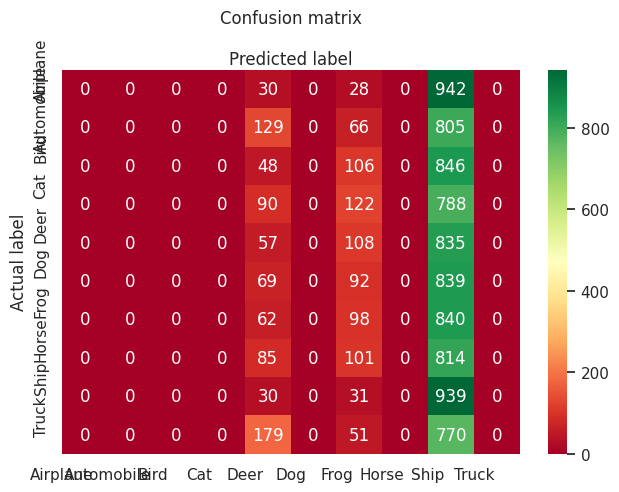

In [ ]:
#Validation
val_loader = torch.utils.data.DataLoader(tensor_cifar10_val, batch_size=64,shuffle=False)

correct = 0
total = 0

y_pred = np.zeros(0)
y_test = np.zeros(0)

with torch.no_grad():
    for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            y_pred = np.append(y_pred,predicted.to('cpu'))
            y_test = np.append(y_test,labels.to('cpu'))
            correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

2023-12-12 17:42:39.149051 Epoch 1, Training loss 2.3064781689582885
2023-12-12 17:48:18.289984 Epoch 10, Training loss 2.3065383556248893
2023-12-12 17:54:39.578684 Epoch 20, Training loss 2.3065168927697575
2023-12-12 18:00:56.986823 Epoch 30, Training loss 2.306515483600099
2023-12-12 18:07:13.498417 Epoch 40, Training loss 2.3065695985198937
2023-12-12 18:13:30.179260 Epoch 50, Training loss 2.3065141052236338
2023-12-12 18:19:48.371044 Epoch 60, Training loss 2.3065921013312574
2023-12-12 18:26:05.761411 Epoch 70, Training loss 2.3065011934246247
2023-12-12 18:32:22.543271 Epoch 80, Training loss 2.306583721924316
2023-12-12 18:38:41.762103 Epoch 90, Training loss 2.3064702511443507
2023-12-12 18:45:02.742226 Epoch 100, Training loss 2.306509653930469
2023-12-12 18:51:21.789320 Epoch 110, Training loss 2.3065589291360373
2023-12-12 18:57:41.033312 Epoch 120, Training loss 2.306604827456462
2023-12-12 19:03:59.543082 Epoch 130, Training loss 2.306517273263858
2023-12-12 19:10:19.65

Text(0.5, 427.9555555555555, 'Predicted label')

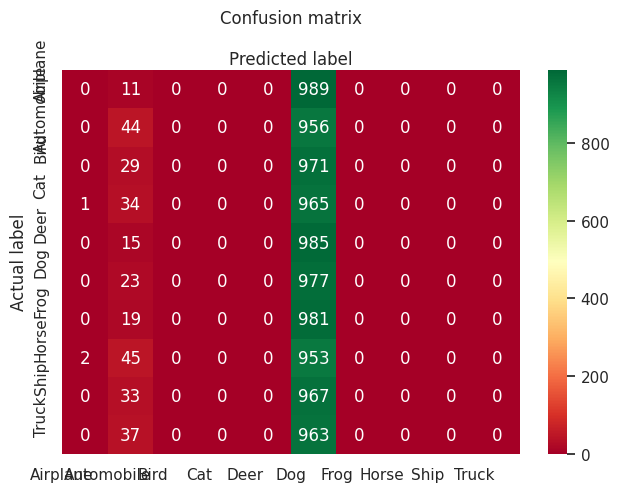

In [ ]:
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,shuffle=True)
#Problem 1b
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, n_out)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net2().to(device=device)
t0 = time.time()
training_loop(n_epochs = n_epochs,optimizer = optimizer,model = model ,loss_fn = loss_fn,train_loader = train_loader)
t1=time.time()
print("Training time:" + str(t1-t0)+ " Seconds")

#Validation
val_loader = torch.utils.data.DataLoader(tensor_cifar10_val, batch_size=64,shuffle=False)

correct = 0
total = 0

y_pred = np.zeros(0)
y_test = np.zeros(0)

with torch.no_grad():
    for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            y_pred = np.append(y_pred,predicted.detach().numpy())
            y_test = np.append(y_test,labels.detach().numpy())
            correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [ ]:
#Problem 2
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,shuffle=True)
def training_loop2(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))



import torch.nn.functional as F
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1,8*8* self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = NetDropout().to(device=device)
loss_fn = nn.CrossEntropyLoss()
t0 = time.time()
n_epochs = 300
training_loop2(n_epochs = n_epochs,optimizer = optimizer,model = model ,loss_fn = loss_fn,train_loader = train_loader)
t1=time.time()
print("Training time:" + str(t1-t0)+ " Seconds")

#Validation
val_loader = torch.utils.data.DataLoader(tensor_cifar10_val, batch_size=64,shuffle=False)

In [ ]:

correct = 0
total = 0

y_pred = np.zeros(0)
y_test = np.zeros(0)

with torch.no_grad():
    for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            y_pred = np.append(y_pred,predicted.detach().numpy())
            y_test = np.append(y_test,labels.detach().numpy())
            correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:

#Problem 2b
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


import torch.nn.functional as F
class NetDropout2(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1,8*8* self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = NetDropout2().to(device=device)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
t0 = time.time()
n_epochs = 300
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64,shuffle=True)
training_loop_l2reg(n_epochs = n_epochs,optimizer = optimizer,model = model ,loss_fn = loss_fn,train_loader = train_loader)
t1=time.time()
print("Training time:" + str(t1-t0)+ " Seconds")

#Validation
val_loader = torch.utils.data.DataLoader(tensor_cifar10_val, batch_size=64,shuffle=False)


2023-12-12 22:09:47.946722 Epoch 1, Training loss 2.0380534348280532
2023-12-12 22:18:54.617375 Epoch 10, Training loss 1.3888320188083307
2023-12-12 22:28:46.519808 Epoch 20, Training loss 1.26358590795256
2023-12-12 22:38:36.477245 Epoch 30, Training loss 1.2102496192583343
2023-12-12 22:48:24.831729 Epoch 40, Training loss 1.1817236103670066
2023-12-12 22:58:12.024500 Epoch 50, Training loss 1.160590761305426
2023-12-12 23:08:04.923842 Epoch 60, Training loss 1.145046768667143
2023-12-12 23:17:54.460143 Epoch 70, Training loss 1.1402837681343487
2023-12-12 23:27:42.591042 Epoch 80, Training loss 1.1273856297173463
2023-12-12 23:37:34.865547 Epoch 90, Training loss 1.1254394379113337
2023-12-12 23:47:29.908556 Epoch 100, Training loss 1.115067350513795
2023-12-12 23:57:22.028952 Epoch 110, Training loss 1.1165735876316305
2023-12-13 00:07:09.292755 Epoch 120, Training loss 1.1070238679571225
2023-12-13 00:17:03.543496 Epoch 130, Training loss 1.1107192339799594
2023-12-13 00:26:55.37

In [ ]:

correct = 0
total = 0

y_pred = np.zeros(0)
y_test = np.zeros(0)

with torch.no_grad():
    for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            y_pred = np.append(y_pred,predicted.detach().numpy())
            y_test = np.append(y_test,labels.detach().numpy())
            correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')